# Inspection of Data

In this notebook we inspect the data used to train and test the model.

In [13]:
# preamble
import numpy as np
from dataloader import get_loader
from utils import train_anno, saliency
from models import UNet, MVCNN_Inception, MVCNN_VGG19, MVCNN_VGG19_early, MVCNN_Baseline, MVCNN_UNet
from torchvision.transforms import transforms
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread_collection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 10e-16

First, we need to load in at least some of the data. We'll start by looking at the training data, come up with some ideas on how we can manipulate the data for better model performance and then check if the manipulation also applies to the test data.

In [14]:
image_path = []
image_path += ['/work3/dgro/Data/Simulator B/JesperN/results/001_hansson_pin_system/001_copenahgen_test_1/7_25/frontalViewImage_20201006_131501.jpg']
image_path += ['/work3/dgro/Data/Simulator B/JesperN/results/001_hansson_pin_system/001_copenahgen_test_1/7_25/lateralViewImage_20201006_131501.jpg']

images = imread_collection([image_path[0], image_path[1]], conserve_memory=True) 

## Visiual inspection of data

First we visually inspect the data. We visualize the data in its original form i.e., without any manipulation applied.

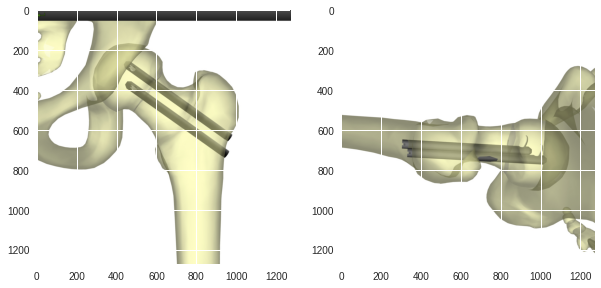

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,20))

axs[0].imshow(images[0])
axs[1].imshow(images[1])

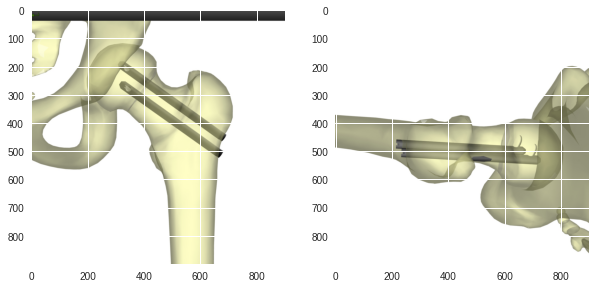

In [16]:
transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((900,900)),
                                    ])

images_resized = [transform(img) for img in images]

fig, axs = plt.subplots(1,2,figsize=(10,20))

axs[0].imshow(images_resized[0])
axs[1].imshow(images_resized[1])

Looks like we can crop from 50-650 and 200-800 for the frontal image and from 150-750 and 150-750 (keeping the original format)

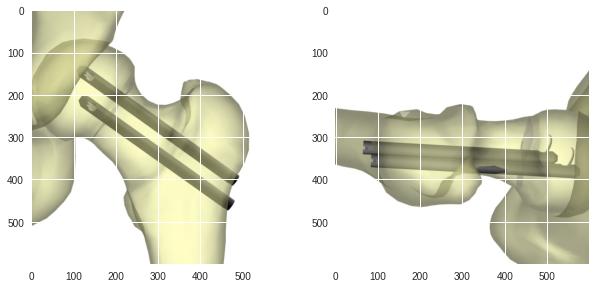

In [19]:
images_crop = []
images_crop += [np.array(images_resized[0])[50:650,200:800]/255]
images_crop += [np.array(images_resized[1])[150:750,150:750]/255]

fig, axs = plt.subplots(1,2,figsize=(10,20))

axs[0].imshow(images_crop[0])
axs[1].imshow(images_crop[1])

In [2]:
idx = np.random.randint(0,batch_size)

image = images[idx]
score = scores[idx]
_, model_slc = saliency(image, model)

fig, ax = plt.subplots(2,2, figsize = (10,10))
fig.suptitle(id_)

ax[0,0].imshow(image.permute(1, 2, 3, 0)[0])
ax[0,0].set_title(f'{score.numpy():.3f}, {preds[idx].item():.3f}')
ax[0,0].imshow(model_slc[0], cmap = plt.cm.hot, alpha = 0.5)

ax[0,1].set_title('Saliency map frontal')
ax[0,1].imshow(model_slc[0], cmap = plt.cm.hot)

ax[1,0].imshow(image.permute(1, 2, 3, 0)[1])
ax[1,0].set_title(f'{score.numpy():.3f}, {preds[idx].item():.3f}')
ax[1,0].imshow(model_slc[1], cmap = plt.cm.hot, alpha = 0.5)

ax[1,1].set_title('Saliency map lateral')
ax[1,1].imshow(model_slc[1], cmap = plt.cm.hot)

plt.show()

RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 3028287488 bytes. Error code 12 (Cannot allocate memory)

In [4]:
outputs = []
scores = []
for k, (images, score, grays, ans) in enumerate(test_loader):
    scores += score.tolist()
    _, preds = model(images)
    outputs += preds.detach().numpy().tolist()

RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 15360000 bytes. Error code 12 (Cannot allocate memory)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,
          1.,   0.,   0.,   2.,   0.,   2.,   2.,   2.,   2.,   2.,   2.,
          9.,  12.,   9.,  27.,  39., 230.]),
 array([-0.99058373, -0.95077354, -0.91096336, -0.87115317, -0.83134299,
        -0.79153281, -0.75172262, -0.71191244, -0.67210226, -0.63229207,
        -0.59248189, -0.5526717 , -0.51286152, -0.47305134, -0.43324115,
        -0.39343097, -0.35362078, -0.3138106 , -0.27400042, -0.23419023,
        -0.19438005, -0.15456987, -0.11475968, -0.0749495 , -0.03513931,
         0.00467087,  0.04448105,  0.08429124,  0.12410142,  0.1639116 ,
         0.20372179,  0.24353197,  0.28334216,  0.32315234,  0.36296252,
         0.40277271,  0.44258289,  0.48239308,  0.52220326,  0.56201344,
         0.60182363,  0.64163381,  0.68144399,  0.72125418,  0.76106436,
 

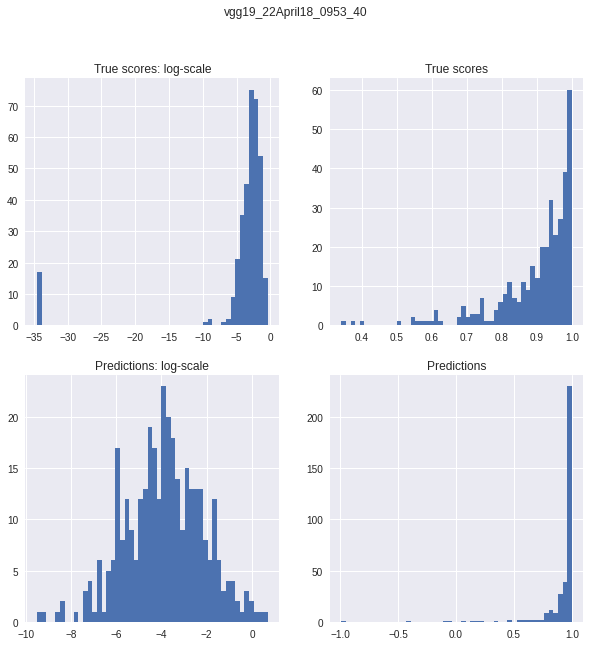

In [61]:
outputs = np.array(outputs)
scores = np.array(scores)

fig, ax = plt.subplots(2,2, figsize = (10,10))
fig.suptitle(id_)

ax[0,0].set_title('True scores: log-scale')
ax[0,0].hist(scores, bins = 50)

ax[1,0].set_title('Predictions: log-scale')
ax[1,0].hist(outputs, bins = 50)

outputs = 1-np.exp(outputs)+eps
scores = 1-np.exp(scores)+eps

ax[0,1].set_title('True scores')
ax[0,1].hist(scores, bins = 50)

ax[1,1].set_title('Predictions')
ax[1,1].hist(outputs, bins = 50)

In [3]:
import torchvision
model = torchvision.models.densenet161(pretrained=True)

Finished loading dataset.


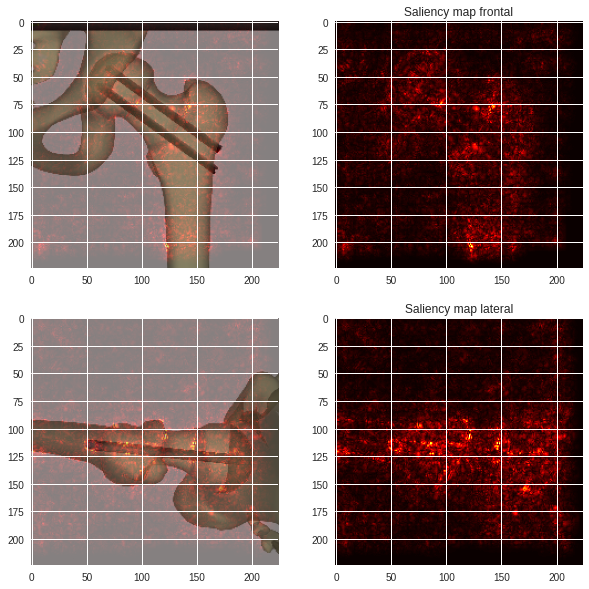

In [28]:
import torchvision
model = torchvision.models.inception_v3(pretrained=True)
model.eval()

repair_type = "001_hansson_pin_system"
size = 224
batch_size = 24

test_transform = val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    ])

test_loader, _, _ = get_loader(repair_type, split = 'test', data_path = "Data", batch_size=batch_size, transform = test_transform, annotation = False, num_workers=0)

images, scores = next(iter(test_loader))

idx = 10

image = images[idx]
score = scores[idx]
_, model_slc = saliency(image[:,0,:,:], model)

plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(image.permute(1, 2, 3, 0)[0])
#plt.title(f'{score.item():.3f}, {preds[idx]:.3f}')
plt.imshow(model_slc, cmap = plt.cm.hot, alpha = 0.5)
plt.subplot(2,2,2)
plt.title('Saliency map frontal')
plt.imshow(model_slc, cmap = plt.cm.hot)

_, model_slc = saliency(image[:,1,:,:], model)
plt.subplot(2,2,3)
plt.imshow(image.permute(1, 2, 3, 0)[1])
#plt.title(f'{score[idx]:.3f}, {preds[idx]:.3f}')
plt.imshow(model_slc, cmap = plt.cm.hot, alpha = 0.5)
plt.subplot(2,2,4)
plt.title('Saliency map lateral')
plt.imshow(model_slc, cmap = plt.cm.hot)

plt.show()

In [17]:
out = model(image[:,1,:,:].unsqueeze(0))
test, indices = torch.max(out, 1)
indices

In [25]:
torchvision.models.re

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 768, 1, 1])

In [8]:
model.eval()
score = model(image[:,1,:,:].unsqueeze(0))
score, indices = torch.max(score, 1)
indices

tensor([889])

In [3]:
image.shape

torch.Size([3, 2, 299, 299])

In [2]:
import torchvision
vgg19 = torchvision.models.vgg19(pretrained=True)

In [3]:
vgg19

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [2]:
import numpy as np
from dataloader import get_loader
from utils import train_anno, saliency
from models import UNet, MVCNN_Inception, MVCNN_VGG19, MVCNN_VGG19_early, MVCNN_Baseline, MVCNN_UNet
from torchvision.transforms import transforms
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
eps = 10e-16

repair_type = "001_hansson_pin_system"
size = 224
batch_size = 2

test_transform = val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((size,size)),
                                    ])

test_loader = get_loader(repair_type, split = 'train', data_path = "Data", batch_size=batch_size, transform = test_transform)

images, scores, grays, ans = next(iter(test_loader))
model = MVCNN_UNet()


Finished loading dataset.


RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 16240345088 bytes. Error code 12 (Cannot allocate memory)

In [5]:
x = images.permute(2,0,1,3,4)
test_unet = []
for i in range(2):
    test_unet += [model.unet(x[i])]

RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 217153536 bytes. Error code 12 (Cannot allocate memory)

In [3]:
test_unet.shape

torch.Size([12, 1, 184, 184])

In [4]:
ans.shape

torch.Size([12, 2, 1, 224, 224])

In [2]:
test, out = model(images)

TypeError: forward() takes 1 positional argument but 2 were given